Install required python lib

In [1]:
!pip install yfinance pandas numpy seaborn matplotlib PyPortfolioOpt riskfolio-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.0/315.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.7 MB/s eta 0:00:00


Import the lib and mount the google drive at /content/drive

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from google.colab import drive
from scipy.optimize import minimize
from pyspark.sql import SparkSession
from pypfopt import risk_models, expected_returns, black_litterman, BlackLittermanModel, EfficientFrontier

drive.mount('/content/drive')

plt.style.use("ggplot")

Mounted at /content/drive


Print out the DAX db with pandas to understand the data structure

In [3]:
# Connect to db and read data
con = sqlite3.connect("/content/drive/MyDrive/data/DAX.db")
df = pd.read_sql("SELECT * FROM DAX;", con)

# Show column names
print(df.columns.tolist())

# Select stocks and DAX, set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


['Date', '1COV.DE', 'ADS.DE', 'AIR.PA', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'BNR.DE', 'CBK.DE', 'CON.DE', 'DB1.DE', 'DBK.DE', 'DHL.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'HNR1.DE', 'IFX.DE', 'MBG.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'PAH3.DE', 'QIA.DE', 'RHM.DE', 'RWE.DE', 'SAP.DE', 'SHL.DE', 'SIE.DE', 'SRT3.DE', 'SY1.DE', 'VNA.DE', 'VOW3.DE', 'ZAL.DE', 'DAX']


In [4]:
# Get the selcted stocks from randomly generated data from part 3
selected_stocks = ["1COV.DE", "ADS.DE", "ALV.DE", "BMW.DE", "DB1.DE", "DHL.DE", "HEI.DE", "MRK.DE", "SRT3.DE", "VOW3.DE"]

# Subset DataFrame for selected stocks and DAX benchmark
df_stocks = df[selected_stocks].copy()
df_dax = df["DAX"].copy()

# Show column names
print(df_stocks.columns.tolist())
print(df_dax.name)

['1COV.DE', 'ADS.DE', 'ALV.DE', 'BMW.DE', 'DB1.DE', 'DHL.DE', 'HEI.DE', 'MRK.DE', 'SRT3.DE', 'VOW3.DE']
DAX


In [5]:
# Download market caps for prior (in Black-Litterman)
market_caps = {}
for ticker in selected_stocks:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info.get('marketCap', None)
mcaps = pd.Series(market_caps)
print("Market Caps:", mcaps)
# Compute historical returns (assume adjusted closes)
returns = df_stocks.pct_change().dropna()

# Estimate inputs for optimization
mu = expected_returns.mean_historical_return(df_stocks)
S = risk_models.sample_cov(df_stocks)

Market Caps: 1COV.DE     11456518144
ADS.DE      29674842112
ALV.DE     145545510912
BMW.DE      54895079424
DB1.DE      46954541056
DHL.DE      47310458880
HEI.DE      36863848448
MRK.DE      48716873728
SRT3.DE     12383997952
VOW3.DE     50570579968
dtype: int64


In [6]:
# Compute daily returns
returns = df_stocks.pct_change().dropna()
dax_returns = df_dax.pct_change().dropna()

# Split into training (2020-01-01 to 2024-01-01) and test sets
train_stocks = df_stocks.loc[:'2024-01-01']
test_stocks = df_stocks.loc['2024-01-02':]

train_returns = train_stocks.pct_change().dropna()
test_returns = test_stocks.pct_change().dropna()

train_dax = df_dax.loc[:'2024-01-01']
test_dax = df_dax.loc['2024-01-02':]

train_dax_returns = train_dax.pct_change().dropna()
test_dax_returns = test_dax.pct_change().dropna()

# Equally Weighted Portfolio (EWP) returns
ew_weights = np.full(len(selected_stocks), 1.0 / len(selected_stocks))
train_ewp_returns = train_returns @ ew_weights
test_ewp_returns = test_returns @ ew_weights

In [7]:
# Compute covariance matrix
cov_matrix = risk_models.sample_cov(train_stocks)

# Market-implied risk aversion
delta = black_litterman.market_implied_risk_aversion(train_dax)

# Market-implied prior returns
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

absolute_views = {
    'ADS.DE': 0.15,
    'SRT3.DE': 0.10,
    'VOW3.DE': -0.05
}

# Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=market_prior, absolute_views=absolute_views)

# Posterior expected returns and covariance
bl_expected_returns = bl.bl_returns()
bl_cov_matrix = bl.bl_cov()

# Optimize for max Sharpe
ef = EfficientFrontier(bl_expected_returns, bl_cov_matrix)
ef.max_sharpe(risk_free_rate=0.01)
bl_weights = ef.clean_weights()

In [8]:
import plotly.graph_objects as go

labels = list(bl_weights.keys())
values = [max(0, v) for v in bl_weights.values()]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3,
                             title="Black-Litterman Portfolio Weights")])
fig.update_layout(title_text="Black-Litterman Portfolio Weights")
fig.show()

In [10]:
# Compute BL portfolio returns
train_bl_returns = train_returns @ pd.Series(bl_weights)
test_bl_returns = test_returns @ pd.Series(bl_weights)

# Function for annualized Sharpe Ratio
def compute_sharpe(returns_series, rf=0.01, periods=252):
    mean_ret = returns_series.mean() * periods
    vol = returns_series.std() * np.sqrt(periods)
    return (mean_ret - rf) / vol

# In-sample Sharpes
train_sharpe_bl = compute_sharpe(train_bl_returns)
train_sharpe_ewp = compute_sharpe(train_ewp_returns)
train_sharpe_dax = compute_sharpe(train_dax_returns)

# Out-of-sample Sharpes
test_sharpe_bl = compute_sharpe(test_bl_returns)
test_sharpe_ewp = compute_sharpe(test_ewp_returns)
test_sharpe_dax = compute_sharpe(test_dax_returns)

# Print Sharpes
print("In-sample Sharpes: BL:", train_sharpe_bl, "EWP:", train_sharpe_ewp, "DAX:", train_sharpe_dax)
print("Out-of-sample Sharpes: BL:", test_sharpe_bl, "EWP:", test_sharpe_ewp, "DAX:", test_sharpe_dax)

# Function for annualized Information Ratio
def compute_ir(returns_port, returns_bench, periods=252):
    diff = returns_port - returns_bench
    return (diff.mean() * periods) / (diff.std() * np.sqrt(periods))

# IRs relative to BL
train_ir_ewp = compute_ir(train_ewp_returns, train_bl_returns)
train_ir_dax = compute_ir(train_dax_returns, train_bl_returns)
test_ir_ewp = compute_ir(test_ewp_returns, test_bl_returns)
test_ir_dax = compute_ir(test_dax_returns, test_bl_returns)

# Print IRs
print("In-sample IRs (vs BL): EWP:", train_ir_ewp, "DAX:", train_ir_dax)
print("Out-of-sample IRs (vs BL): EWP:", test_ir_ewp, "DAX:", test_ir_dax)

In-sample Sharpes: BL: 0.28943699671071416 EWP: 0.4515332713121024 DAX: 0.31639346473235375
Out-of-sample Sharpes: BL: 0.4259134692999593 EWP: 0.5670940024389846 DAX: 1.492487300400244
In-sample IRs (vs BL): EWP: 0.35095110418866066 DAX: -0.02159443029599787
Out-of-sample IRs (vs BL): EWP: 0.1474906225642627 DAX: 1.2924186490972378


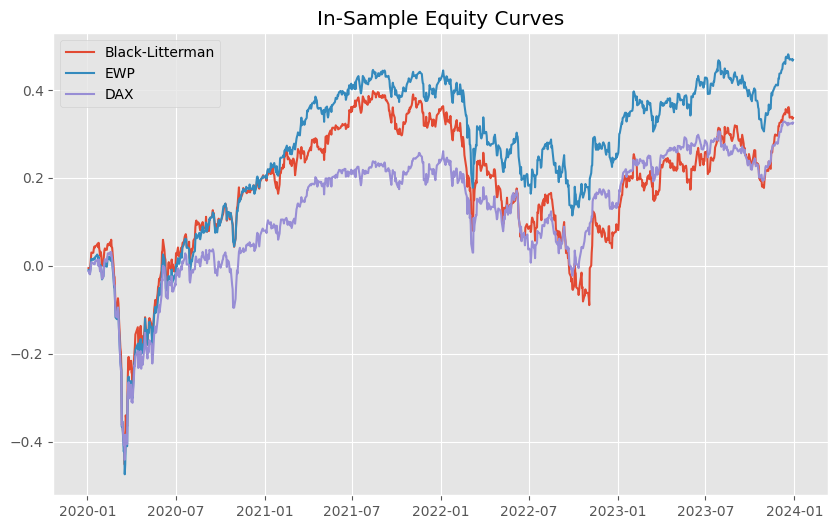

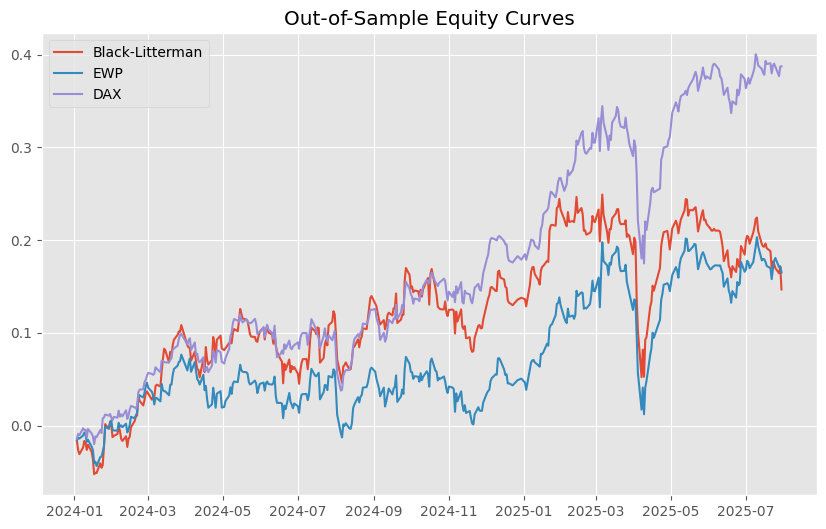

In [11]:
# In-sample equity curves
plt.figure(figsize=(10, 6))
plt.plot(train_bl_returns.cumsum(), label="Black-Litterman")
plt.plot(train_ewp_returns.cumsum(), label="EWP")
plt.plot(train_dax_returns.cumsum(), label="DAX")
plt.title("In-Sample Equity Curves")
plt.legend()
plt.show()

# Out-of-sample equity curves
plt.figure(figsize=(10, 6))
plt.plot(test_bl_returns.cumsum(), label="Black-Litterman")
plt.plot(test_ewp_returns.cumsum(), label="EWP")
plt.plot(test_dax_returns.cumsum(), label="DAX")
plt.title("Out-of-Sample Equity Curves")
plt.legend()
plt.show()